<h1> Machine Learning Models </h1>

<h2>  Converting tags for multilabel problems </h2>

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

In [3]:
import os
os.path

<module 'ntpath' from 'C:\\Users\\ankan\\Anaconda3\\lib\\ntpath.py'>

In [2]:
os.chdir('C:\\Users\\ankan\\Desktop\\Stack')

In [3]:
from wordcloud import WordCloud
import sqlite3
import re
import pandas as pd
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os as os
import seaborn as sns
import warnings
import csv
from PIL import Image

In [5]:
data = pd.read_csv('data_100k_finally_filtered.csv')

In [6]:
data.head()

,Unnamed: 0,Title,Body,Tags,Question,tag_count
0,0,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,how to check if an upload file is an imag with...,5
1,1,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,how can i prevent firefox from close when i pr...,1
2,2,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,r error invalid type list for variabl i am imp...,3
3,3,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding,how do i replac special charact in a url this ...,3
4,4,How to modify whois contact details?,<pre><code>function modify(.......)\r\r\n{\r\r...,php api file-get-contents,how to modifi whoi contact detail function mod...,3


In [7]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(data['Tags'])

In [8]:
multilabel_y

<99436x18448 sparse matrix of type '<class 'numpy.int64'>'
	with 286677 stored elements in Compressed Sparse Row format>

In [9]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [10]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

In [11]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [10, 5]
warnings.filterwarnings("ignore", category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

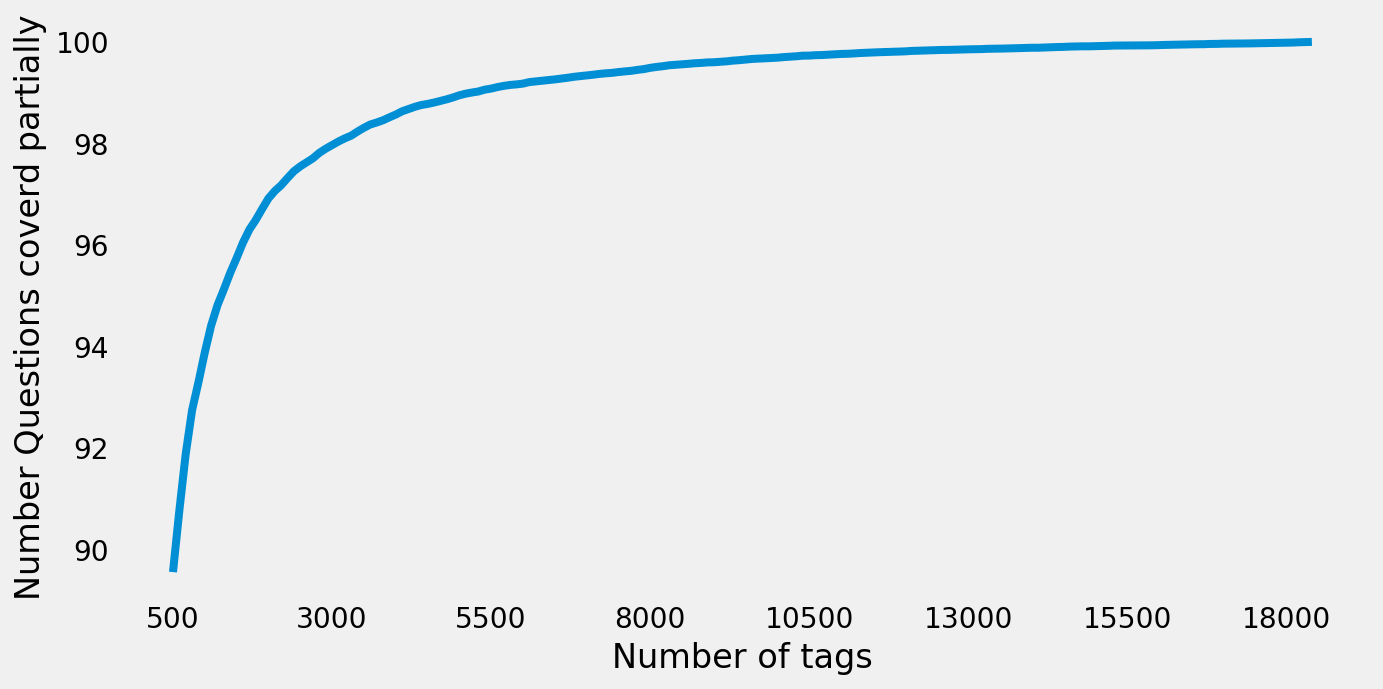

In [12]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()


In [13]:
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

with  5500 tags we are covering  99.079 % of questions
with  500 tags we are covering  89.551 % of questions


In [14]:
multilabel_yx = tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

number of questions that are not covered : 916 out of  99436


In [15]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 18448
number of tags taken : 5500 ( 29.81352992194276 %)


<h2>Split the data into test and train (80:20) </h2>

In [16]:
total_size=data.shape[0]
train_size=int(0.90*total_size)

x_train=data.head(train_size)
x_test=data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)


Number of data points in train data : (89492, 5500)
Number of data points in test data : (9944, 5500)


<h2>Featurizing data </h2>

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,4))
x_train_multilabel = vectorizer.fit_transform(x_train['Question'])
x_test_multilabel = vectorizer.transform(x_test['Question'])
print("Time taken to run this cell :", datetime.now() - start)

In [ ]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

<h3>  Applying Logistic Regression with OneVsRest Classifier </h3>

In [31]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.07843925985518906
Hamming loss  0.00041474072990565347
Micro-average quality numbers
Precision: 0.7205, Recall: 0.2298, F1-measure: 0.3485


C:\Users\ankan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ankan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\ankan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ankan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Macro-average quality numbers
Precision: 0.0789, Recall: 0.0310, F1-measure: 0.0416


C:\Users\ankan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ankan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


             precision    recall  f1-score   support

          0       0.74      0.36      0.48       771
          1       0.76      0.47      0.58       668
          2       0.81      0.61      0.70       662
          3       0.77      0.44      0.56       628
          4       0.95      0.75      0.84       501
          5       0.86      0.66      0.75       513
          6       0.88      0.50      0.64       343
          7       0.89      0.67      0.76       309
          8       0.71      0.45      0.55       291
          9       0.75      0.38      0.50       279
         10       0.80      0.56      0.66       264
         11       0.51      0.15      0.24       261
         12       0.59      0.11      0.19       286
         13       0.55      0.23      0.33       209
         14       0.55      0.27      0.37       209
         15       0.57      0.23      0.33       219
         16       0.85      0.47      0.61       214
         17       0.63      0.25      0.36   

In [33]:
from sklearn.externals import joblib
joblib.dump(classifier, 'one vs rest lr.pkl') 

['one vs rest lr.pkl']